In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disease/Training/Late_Blight/Late_Blight_64.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_221.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_213.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_1051.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_790.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_612.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_359.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_211.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_700.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_251.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_860.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_576.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_1063.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_1056.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Blight_106.jpg
/kaggle/input/disease/Training/Late_Blight/Late_Bligh

In [50]:
import io
import os
from warnings import filterwarnings

from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, ReLU, GlobalAveragePooling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [52]:
train_path = "/kaggle/input/disease/Training"
test_path = "/kaggle/input/disease/Testing"

In [53]:
labels = ['Early_Blight', 'Healthy', 'Late_Blight']

In [54]:
X_train, y_train = [], []
X_test, y_test = [], []

image_size = 150
i=0
for label in labels:
    folderPath = os.path.join(train_path, label)
    for fn in tqdm(os.listdir(folderPath)):
        fnPath = os.path.join(folderPath, fn)
        img = cv2.imread(fnPath)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    i=i+1

j=0
for label in labels:
    folderPath = os.path.join(test_path, label)
    for fn in tqdm(os.listdir(folderPath)):
        fnPath = os.path.join(folderPath, fn)
        img = cv2.imread(fnPath)
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(j)
    j=j+1
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

100%|██████████| 141/141 [00:00<00:00, 594.88it/s]


((3251, 150, 150, 3), (3251,), (405, 150, 150, 3), (405,))

In [55]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [56]:
print(y_train)
print(y_train.shape)
print(y_test)
print(y_test.shape)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(3251, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(405, 3)


In [57]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=42, stratify=y_train)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2600, 150, 150, 3), (2600, 3), (651, 150, 150, 3), (651, 3))

In [58]:
train_datagen = ImageDataGenerator (
    rotation_range = 30,
    rescale = 1./255,
    
    shear_range = 0.1,
    zoom_range = 0.2,
    
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [72]:
batch_size = 32
train_gen = train_datagen.flow(
    X_train, y_train, 
    batch_size=batch_size
)

val_gen = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size
)


In [79]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

In [80]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.0001,
                              mode='auto',verbose=1)

In [81]:
epochs = 25

history = model.fit (
    train_gen,
    epochs = epochs,
    validation_data = val_gen,
    validation_steps = len(y_val)//batch_size,
    steps_per_epoch = len(y_train)//batch_size,
    callbacks = [tensorboard,checkpoint,reduce_lr],
    verbose = 1,
)

Epoch 1/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8382 - loss: 0.3782
Epoch 1: val_accuracy improved from -inf to 0.25313, saving model to effnet.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 139s 748ms/step - accuracy: 0.8393 - loss: 0.3761 - val_accuracy: 0.2531 - val_loss: 3.0383 - learning_rate: 0.0010
Epoch 2/25
 1/81 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8438 - loss: 0.3599
Epoch 2: val_accuracy did not improve from 0.25313
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8438 - loss: 0.3599 - val_accuracy: 0.0909 - val_loss: 3.6672 - learning_rate: 0.0010
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9748 - loss: 0.0727
Epoch 3: val_accuracy did not improve from 0.25313

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.9747 - loss: 0.0728 - val_accuracy: 0.2500 - val_loss: 6.9078 - learning_rate: 0.0010
Epoch 4/25
 1/81 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accu

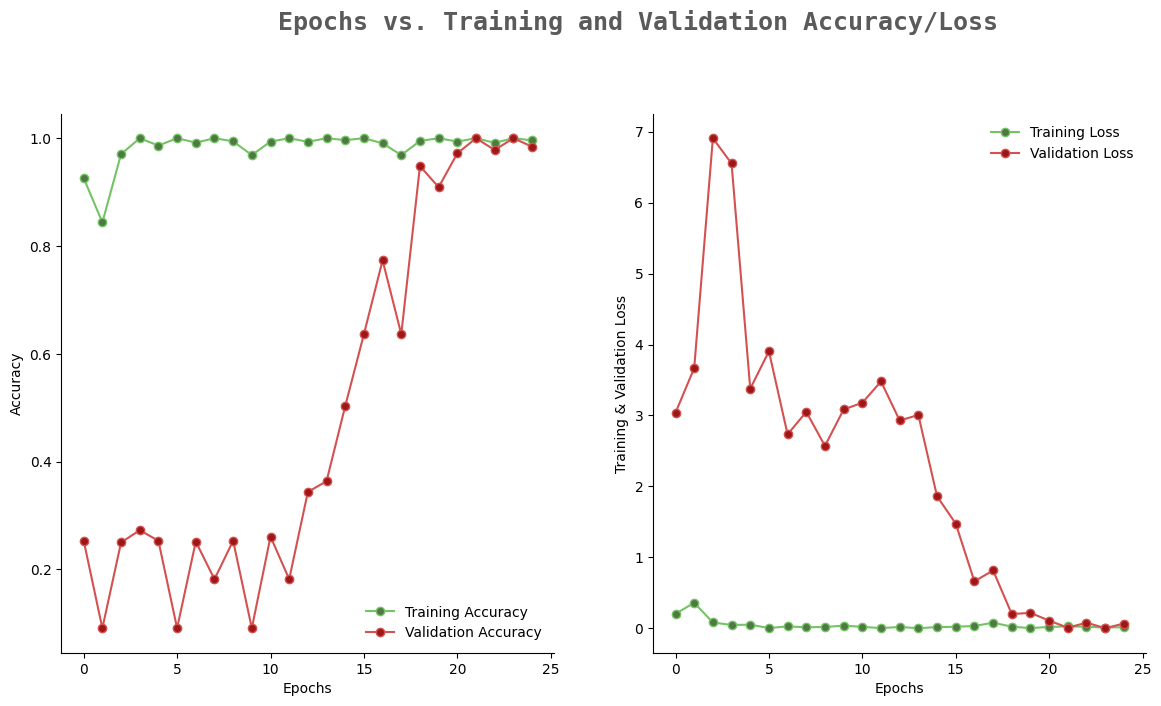

In [82]:
filterwarnings('ignore')

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

range_epochs = [i for i in range(epochs)]
fig, ax = plt.subplots(1, 2, figsize=(14,7))
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(range_epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(range_epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(range_epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(range_epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [83]:
pred = model.predict(X_test / 255)  # rescale
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test,axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step


In [84]:
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       162
           1       0.98      1.00      0.99       102
           2       1.00      0.99      0.99       141

    accuracy                           0.99       405
   macro avg       0.99      0.99      0.99       405
weighted avg       0.99      0.99      0.99       405

